<h1> Veštačke neuronske mreže </h1>

Skup podata sadrži rezultate simulacija stabilnosti za referentnu zvezdastu mrežu sa 4 čvora. Sadrži 60.000 zapažanja. Takođe sadrži 12 karakteristika i dve zavisne promenljive.
Cilj je predvideti stabilnost pametne mreže.

Skup podataka nalazi se na linku: <a> https://www.kaggle.com/pcbreviglieri/smart-grid-stability </a>. 

<b> Karakteristike: </b>
<ul>
<li> <b> „tau1“ - „tau4“ </b>: vreme reakcije svakog učesnika mreže, stvarna vrednost u opsegu 0,5 do 10, gde„tau1“ odgovara čvoru dobavljača, „tau2“ do „tau4“ potrošačkim čvorovima. </li>
<li> <b>„p1“ - „p4“ </b>: nominalna snaga koju proizvodi (pozitivno) ili troši (negativno) svaki učesnik mreže, stvarna vrednost u rasponu od -2,0 do -0,5 za potrošače („p2“ do „p4“). Kako je ukupna potrošena snaga jednaka ukupnoj proizvedenoj snazi, p1 (čvor dobavljača) = - (p2 + p3 + p4) </li>
<li><b>'g1' - 'g4' </b>: koeficijent elastičnosti cena za svakog učesnika u mreži, stvarna vrednost u opsegu 0,05 do 1,00, gde 'g1' odgovara čvoru dobavljača, 'g2' do 'g4' potrošačkim čvorovima. </li>
</ul>
<b>Zavisne promenljive: </b>
<ul>
    <li> <b>„stab“ </b>: maksimalni reani deo karakterističnog korena jednačine diferencijacije (ako je pozitivan, sistem je linearno nestabilan; ako je negativan, linearno stabilan). </li>
<li> <b> „stabf“: </b>  oznaka „stabilna“ ili „nestabilna“ (stable/unstable).</li>
</ul>


In [36]:
import tensorflow as tf
import keras
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import layers
import keras.backend as K
from sklearn.decomposition import PCA
from keras import regularizers
from keras.regularizers import l2
from keras.regularizers import l1

<h1> Učitavanje podataka <h1>

In [2]:
missing_values = ["n/a", "na", "--","NaN","Na"]
dataset=pd.read_csv('D:\Marija\MachineLearning\smart_grid_stability_augmented.csv',na_values = missing_values)

<h1> Preprocesiranje i deskriptivna statistika podataka </h1>

In [3]:
print("Missing values:\n") 
print(dataset.isnull().sum().sort_values(ascending=False))

Missing values:

stabf    0
stab     0
g4       0
g3       0
g2       0
g1       0
p4       0
p3       0
p2       0
p1       0
tau4     0
tau3     0
tau2     0
tau1     0
dtype: int64


In [4]:
print("Numbr of duplicates:" , dataset.duplicated().sum())

Numbr of duplicates: 0


Kako je sadržaj skupa podataka rezultat simulacije , vrednosti ne nedostaju i nema duplikata.

In [5]:
print('Descriptive statistic of dataset:')
print(dataset.describe())
print('\nMedian:')
print(dataset.median())
print('\nVariance:')
print(dataset.var())

Descriptive statistic of dataset:
               tau1          tau2          tau3          tau4            p1  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       5.250000      5.250001      5.250001      5.250001      3.750000   
std        2.742434      2.742437      2.742437      2.742437      0.752129   
min        0.500793      0.500141      0.500141      0.500141      1.582590   
25%        2.874892      2.875011      2.875011      2.875011      3.218300   
50%        5.250004      5.249981      5.249981      5.249981      3.751025   
75%        7.624690      7.624896      7.624896      7.624896      4.282420   
max        9.999469      9.999837      9.999837      9.999837      5.864418   

                 p2            p3            p4            g1            g2  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean      -1.250000     -1.250000     -1.250000      0.525000      0.525000   
std        0.4330

Text(0.5, 1.0, 'Stability distribution')

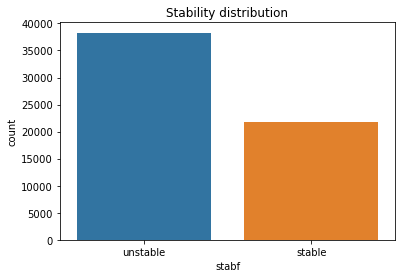

In [6]:
ax = sns.countplot(x='stabf', data=dataset)
plt.title('Stability distribution')

Text(0.5, 1.0, 'Stability distribution')

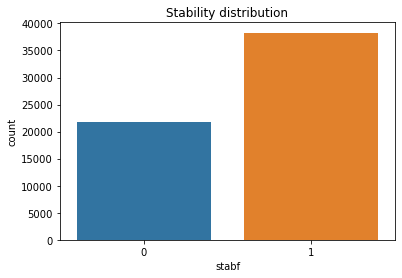

In [8]:
ax = sns.countplot(x='stabf', data=dataset)
plt.title('Stability distribution')

Nakon prevođenja kategoričkog atributa "stabf", vrednost unstable je označena sa 1 , stable sa 0.

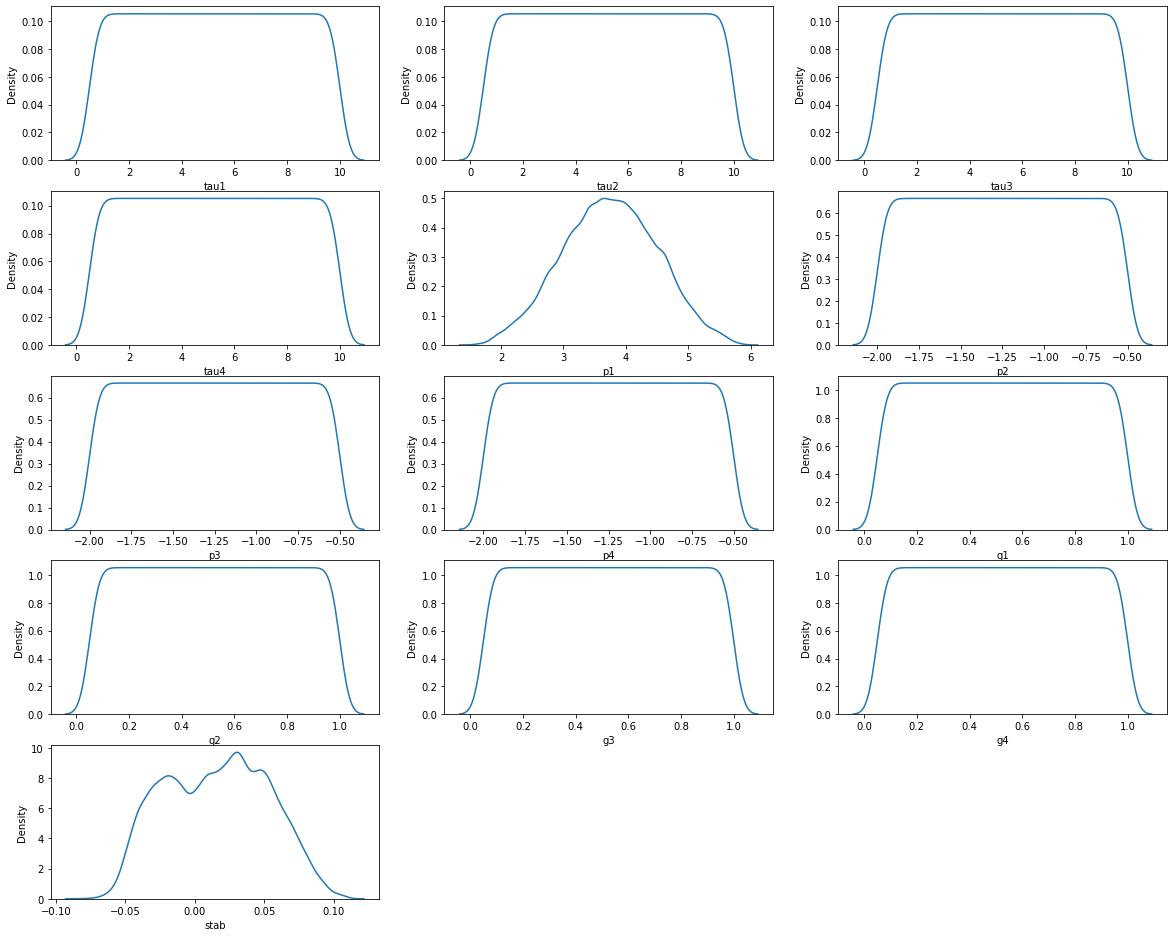

In [7]:
plt.figure(figsize=(20,30))
for i, col in enumerate(dataset.columns):
    if dataset[col].dtype != 'object':
        ax = plt.subplot(9, 3, i+1)
        sns.kdeplot(dataset[col], ax=ax)
        plt.xlabel(col)     
plt.show()

In [7]:
le = preprocessing.LabelEncoder()
dataset.stabf = le.fit_transform(dataset.stabf)

In [4]:
dataset

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,1
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,0
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,1
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,1
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2.930406,2.376523,9.487627,6.187797,3.343416,-1.449106,-0.658054,-1.236256,0.601709,0.813512,0.779642,0.608385,0.023892,1
59996,3.392299,2.954947,1.274827,6.894759,4.349512,-0.952437,-1.663661,-1.733414,0.502079,0.285880,0.567242,0.366120,-0.025803,0
59997,2.364034,8.776391,2.842030,1.008906,4.299976,-0.943884,-1.380719,-1.975373,0.487838,0.149286,0.986505,0.145984,-0.031810,0
59998,9.631511,2.757071,3.994398,7.821347,2.514755,-0.649915,-0.966330,-0.898510,0.365246,0.889118,0.587558,0.818391,0.037789,1


Text(0.5, 1.0, 'Correlation Heatmap')

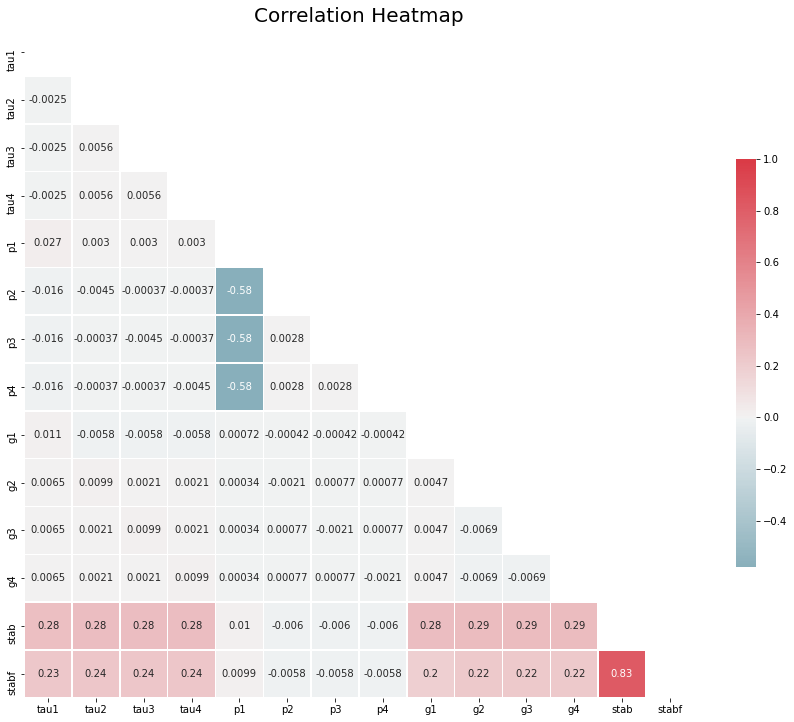

In [86]:
corr = dataset.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(15,15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask,annot=True, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Heatmap', fontsize=20)

Kako postoji direktna veza između „stab“ i „stabf“ („stabf“ = „stable“ ako je „stab“ <= 0, u suprotnom „unstable“), „stabf“ će ostati kao jedina zavisna promenljiva

In [9]:
X=dataset.iloc[:, :-2].values
y=dataset.iloc[:, 13].values

In [10]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_scaled=scaler.fit_transform(X)

<h1> Kreiranje modela </h1>

Kreiramo mrežu sa tri sloja. Model očekuje redove podataka sa 12 karakteristika ( input_dim = 12)
Prvi skriveni sloj ima 10 čvorova (neurona) i koristi Rectified Linear Unit (ReLU) aktivacionu funkciju.
Drugi skriveni sloj ima 6 čvorova (neurona) i takođe koristi ReLu funkciju aktivacije.
Izlazni sloj ima jedan čvor i koristi sigmoidnu funkciju aktivacije. 
Koristimo sigmoidnu funkciju na izlazu, kako bismo osigurali da je  izlaz između 0 i 1 i da ga je lako mapirati klase sa zadanim pragom od 0,5.
Koristi se binary crossentropy funkcija gubitka. proces učenja odvija se u 50 epoha i 1000 serija. 

In [109]:

classifier = Sequential()
classifier.add(Dense( 10,  kernel_initializer = 'uniform', activation = 'relu' , input_dim = 12))
classifier.add(Dense( 6,  kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense( 1,  kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ["accuracy"] )

In [138]:
history=classifier.fit(X_train, y_train, validation_data = (X_test,y_test), batch_size=1000 , epochs=50 )

Epoch 1/50
42/42 [==============================] - 18s 121ms/step - loss: 0.1439 - accuracy: 0.9389 - val_loss: 0.1496 - val_accuracy: 0.9377
Epoch 2/50
42/42 [==============================] - 0s 8ms/step - loss: 0.1419 - accuracy: 0.9403 - val_loss: 0.1485 - val_accuracy: 0.9375
Epoch 3/50
42/42 [==============================] - 0s 8ms/step - loss: 0.1413 - accuracy: 0.9409 - val_loss: 0.1481 - val_accuracy: 0.9372
Epoch 4/50
42/42 [==============================] - 0s 6ms/step - loss: 0.1410 - accuracy: 0.9411 - val_loss: 0.1478 - val_accuracy: 0.9372
Epoch 5/50
42/42 [==============================] - 0s 5ms/step - loss: 0.1409 - accuracy: 0.9412 - val_loss: 0.1477 - val_accuracy: 0.9373
Epoch 6/50
42/42 [==============================] - 0s 5ms/step - loss: 0.1408 - accuracy: 0.9413 - val_loss: 0.1475 - val_accuracy: 0.9378
Epoch 7/50
42/42 [==============================] - 0s 5ms/step - loss: 0.1407 - accuracy: 0.9415 - val_loss: 0.1474 - val_accuracy: 0.9378
Epoch 8/50
42/42 

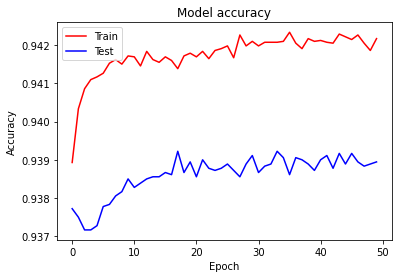

In [139]:
plt.plot(history.history['accuracy'], "r-")
plt.plot(history.history['val_accuracy'],  "b-")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

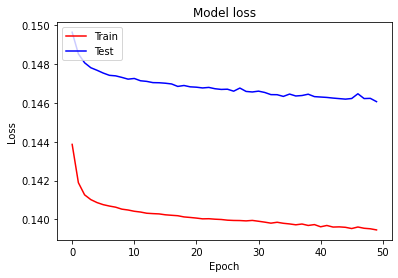

In [140]:
plt.plot(history.history['loss'],"r-") 
plt.plot(history.history['val_loss'],"b-") 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

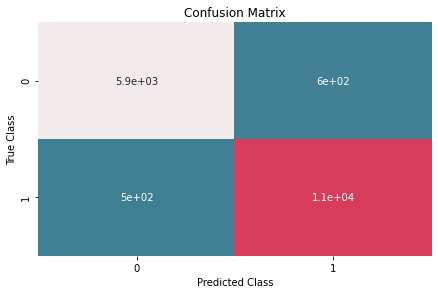

In [141]:
y_pred = classifier.predict(X_test)
y_pred=(y_pred > 0.5)
matrix = confusion_matrix(y_test, y_pred)
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)
cmap = sns.diverging_palette(220, 5, as_cmap=True)
sns.heatmap(dataframe, annot=True, cbar=None, cmap=cmap)
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [142]:
print("\nClassification report:\n")
target_names = ['0', '1']
print(classification_report(y_test, y_pred, target_names=target_names))


Classification report:

              precision    recall  f1-score   support

           0       0.92      0.91      0.91      6516
           1       0.95      0.96      0.95     11484

    accuracy                           0.94     18000
   macro avg       0.94      0.93      0.93     18000
weighted avg       0.94      0.94      0.94     18000



<h2> Smanjivanje overfitinga ranim zaustavljanjem (Early Stopping) </h2>

In [10]:
classifier = Sequential()
classifier.add(Dense( 10,  kernel_initializer = 'uniform', activation = 'relu' , input_dim = 12))
classifier.add(Dense( 6,  kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense( 1,  kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ["accuracy"] )

In [22]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [EarlyStopping(monitor="val_loss", patience=2)]

In [12]:
history=classifier.fit(X_train, y_train,callbacks=callbacks, validation_data = (X_test,y_test), batch_size=1000 , epochs=60 )

Epoch 1/60
42/42 [==============================] - 6s 79ms/step - loss: 0.6915 - accuracy: 0.6213 - val_loss: 0.6847 - val_accuracy: 0.6341
Epoch 2/60
42/42 [==============================] - 0s 4ms/step - loss: 0.6796 - accuracy: 0.6365 - val_loss: 0.6561 - val_accuracy: 0.6348
Epoch 3/60
42/42 [==============================] - 0s 5ms/step - loss: 0.6398 - accuracy: 0.6772 - val_loss: 0.5816 - val_accuracy: 0.8005
Epoch 4/60
42/42 [==============================] - 0s 4ms/step - loss: 0.5553 - accuracy: 0.8123 - val_loss: 0.4888 - val_accuracy: 0.8118
Epoch 5/60
42/42 [==============================] - 0s 4ms/step - loss: 0.4665 - accuracy: 0.8175 - val_loss: 0.4304 - val_accuracy: 0.8117
Epoch 6/60
42/42 [==============================] - 0s 4ms/step - loss: 0.4191 - accuracy: 0.8147 - val_loss: 0.4077 - val_accuracy: 0.8121
Epoch 7/60
42/42 [==============================] - 0s 4ms/step - loss: 0.4005 - accuracy: 0.8145 - val_loss: 0.3998 - val_accuracy: 0.8131
Epoch 8/60
42/42 [=

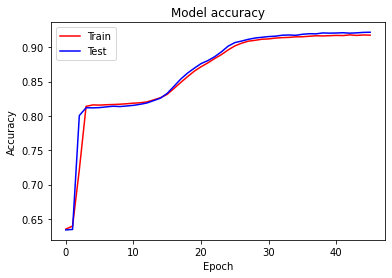

In [13]:
plt.plot(history.history['accuracy'], "r-")
plt.plot(history.history['val_accuracy'],  "b-")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

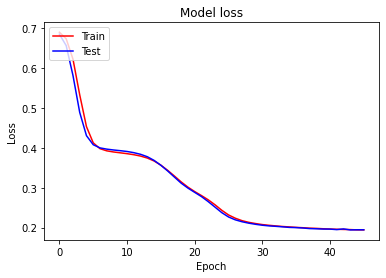

In [14]:
plt.plot(history.history['loss'],"r-") 
plt.plot(history.history['val_loss'],"b-") 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

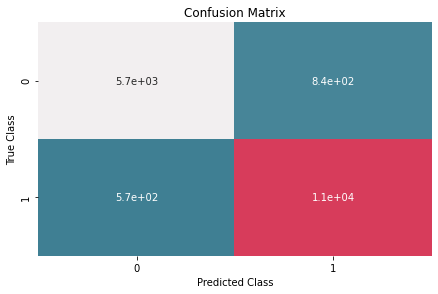

In [18]:
y_pred = classifier.predict(X_test)
y_pred=(y_pred > 0.5)
class_names=[0,1]
matrix = confusion_matrix(y_test, y_pred)
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)
cmap = sns.diverging_palette(220, 5, as_cmap=True)
sns.heatmap(dataframe, annot=True, cbar=None, cmap=cmap)
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [44]:
accuracy_Cross = accuracy_score(y_test, y_pred)
print("\nClassification report:\n")
target_names = ['0', '1']
print(classification_report(y_test, y_pred, target_names=target_names))


Classification report:

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      6586
           1       0.93      0.95      0.94     11414

    accuracy                           0.92     18000
   macro avg       0.92      0.91      0.91     18000
weighted avg       0.92      0.92      0.92     18000



<h2> Vizuelizacija veštačke neuronske mreže koja se koristi </h2>

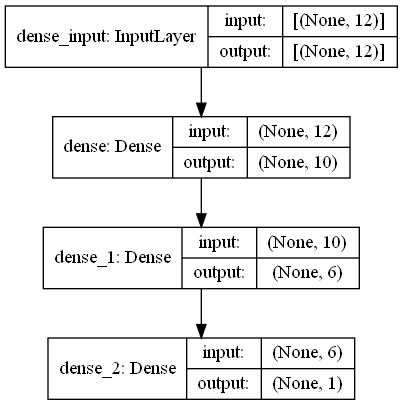

In [31]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
SVG(model_to_dot(classifier, show_shapes=True).create(prog="dot", format="svg"))
plot_model(classifier, show_shapes=True, to_file="network.png")

<h2> Podešavanje mreže - odabir najbojih hipermapametara mreže </h2>

Iz prethodnih rezultata se može videti da je odabrana arihitektura mreže (3 sloja sa odgovarajućim brojem neurona) dala dobre rezultate. Zbog toga arhitektura neće biti promenjena, ali je potrebno pretražiti hiperparametre, da bi se što bolje odabrao broj epoha i serija, kao i optimizator.
Koristi se GridSearch za pretragu hiperparametara.

In [19]:
number_of_features=12
def create_network(optimizer="adam"):
    network = Sequential()
    network.add(layers.Dense(units=10, activation="relu",input_shape=(number_of_features,)))
    network.add(layers.Dense(units=6, activation="relu"))
    network.add(layers.Dense(units=1, activation="sigmoid"))
    network.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return network

In [37]:

neural_network = KerasClassifier(build_fn=create_network, verbose=0)
epochs = [60,100]
batches = [50,100,1000]
optimizers = ["adam","rmsprop"]
hyperparameters = dict(optimizer=optimizers, epochs=epochs, batch_size=batches)
grid = GridSearchCV(estimator=neural_network, param_grid=hyperparameters)
grid_result = grid.fit(X_scaled, y)

In [38]:
grid_result.best_params_

{'batch_size': 100, 'epochs': 100, 'optimizer': 'adam'}

Nadalje će broj epoha i serija biti 100, i koristiće se adam optimizator. Koristiće se različite funkcije gubitka (loss fje).

<h2> Binary crossentropy </h2>

In [24]:
def create_network_crossentropy():
    network = Sequential()
    network.add(layers.Dense(units=10, activation="relu",input_shape=(number_of_features,)))
    network.add(layers.Dense(units=6, activation="relu"))
    network.add(layers.Dense(units=1, activation="sigmoid"))
    network.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return network

In [25]:
neural_network = KerasClassifier(build_fn=create_network_crossentropy, epochs=100, batch_size=100, verbose=0)
print("Cross-validation score with crossentropy loss",cross_val_score(neural_network, X_scaled, y, cv=20))

Cross-validation score with crossentropy loss [0.95599997 0.96366668 0.94566667 0.95633334 0.96033335 0.95733333
 0.96066666 0.95833331 0.95066667 0.94700003 0.95533335 0.94466668
 0.95933336 0.94800001 0.95599997 0.96333331 0.95700002 0.94733334
 0.95966667 0.95733333]


In [26]:
history=neural_network.fit(X_train, y_train,callbacks=callbacks, validation_data = (X_test,y_test))

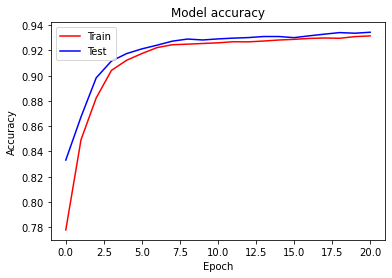

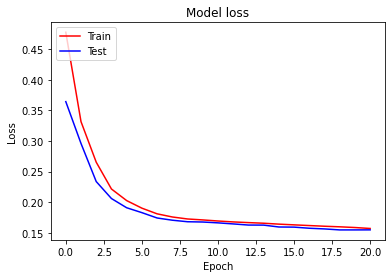

In [27]:
plt.plot(history.history['accuracy'], "r-")
plt.plot(history.history['val_accuracy'],  "b-")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'],"r-") 
plt.plot(history.history['val_loss'],"b-") 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()


Classification report:

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      6536
           1       0.95      0.95      0.95     11464

    accuracy                           0.93     18000
   macro avg       0.93      0.93      0.93     18000
weighted avg       0.93      0.93      0.93     18000



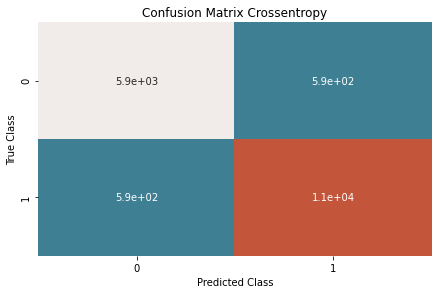

In [30]:
y_pred = neural_network.predict(X_test)
y_pred=(y_pred > 0.5)
accuracy_crossentropy = accuracy_score(y_test, y_pred)
print("\nClassification report:\n")
target_names = ['0', '1']
class_names=[0,1]
print(classification_report(y_test, y_pred, target_names=target_names))
matrix = confusion_matrix(y_test, y_pred)
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(dataframe, annot=True, cbar=None, cmap=cmap)
plt.title("Confusion Matrix Crossentropy"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

<h2> Hinge loss </h2>

In [31]:
def create_network_hinge():
    network = Sequential()
    network.add(layers.Dense(units=10, activation="relu",input_shape=(number_of_features,)))
    network.add(layers.Dense(units=6, activation="relu"))
    network.add(layers.Dense(units=1, activation="sigmoid"))
    network.compile(loss="hinge", optimizer="adam", metrics=["accuracy"])
    return network

In [32]:
neural_network_hinge = KerasClassifier(build_fn=create_network_hinge, epochs=100, batch_size=100, verbose=0)
print("Cross-validation score hinge loss function" ,cross_val_score(neural_network_hinge, X_scaled, y, cv=20))

Cross-validation score hinge loss function [0.94       0.88966668 0.93599999 0.88366669 0.935      0.93566668
 0.88966668 0.89966667 0.86566669 0.88466668 0.86566669 0.94400001
 0.93133336 0.93033332 0.94333333 0.94466668 0.93133336 0.93199998
 0.88200003 0.94566667]


In [33]:
history_hinge=neural_network_hinge.fit(X_train, y_train,callbacks=callbacks, validation_data = (X_test,y_test))

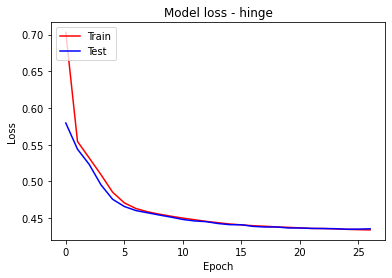

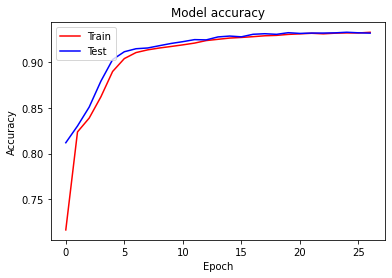

In [34]:
plt.plot(history_hinge.history['loss'],"r-") 
plt.plot(history_hinge.history['val_loss'],"b-") 
plt.title('Model loss - hinge') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()
plt.plot(history_hinge.history['accuracy'], "r-")
plt.plot(history_hinge.history['val_accuracy'],  "b-")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


Classification report:

              precision    recall  f1-score   support

           0       0.94      0.87      0.90      6536
           1       0.93      0.97      0.95     11464

    accuracy                           0.93     18000
   macro avg       0.93      0.92      0.92     18000
weighted avg       0.93      0.93      0.93     18000



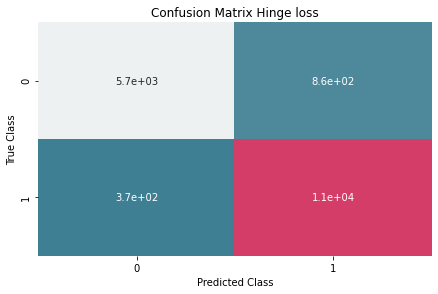

In [35]:
y_pred = neural_network_hinge.predict(X_test)
y_pred=(y_pred > 0.5)
accuracy_hinge = accuracy_score(y_test, y_pred)
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=target_names))
matrix = confusion_matrix(y_test, y_pred)
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)
cmap = sns.diverging_palette(220, 0, as_cmap=True)
sns.heatmap(dataframe, annot=True, cbar=None, cmap=cmap)
plt.title("Confusion Matrix Hinge loss"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

<h2> Squared hinge </h2>

In [36]:
def create_network_squared_hinge():
    network = Sequential()
    network.add(layers.Dense(units=10, activation="relu",input_shape=(number_of_features,)))
    network.add(layers.Dense(units=6, activation="relu"))
    network.add(layers.Dense(units=1, activation="sigmoid"))
    network.compile(loss="squared_hinge", optimizer="adam", metrics=["accuracy"])
    return network

In [37]:
neural_network_squared_hinge = KerasClassifier(build_fn=create_network_squared_hinge, epochs=100, batch_size=100, verbose=0)
print("Cross-validation score squared hinge loss function" ,cross_val_score(neural_network_squared_hinge, X_scaled, y, cv=20))

Cross-validation score squared hinge loss function [0.94566667 0.94066668 0.93633336 0.93699998 0.94633335 0.95033336
 0.94       0.93900001 0.94533336 0.954      0.93599999 0.93699998
 0.95433331 0.93599999 0.95033336 0.94333333 0.94       0.93766665
 0.93433332 0.92799997]


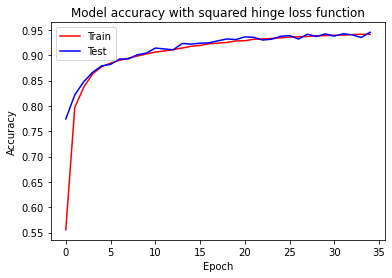

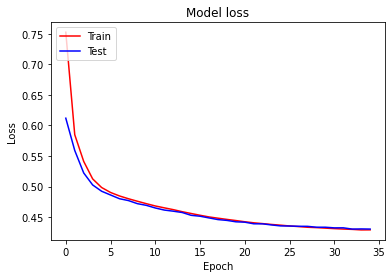

In [38]:
history_squared_hinge=neural_network_squared_hinge.fit(X_train, y_train,callbacks=callbacks, validation_data = (X_test,y_test))
plt.plot(history_squared_hinge.history['accuracy'], "r-")
plt.plot(history_squared_hinge.history['val_accuracy'],  "b-")
plt.title('Model accuracy with squared hinge loss function')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.plot(history_squared_hinge.history['loss'],"r-") 
plt.plot(history_squared_hinge.history['val_loss'],"b-") 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()


Classification report:

              precision    recall  f1-score   support

           0       0.88      0.98      0.93      6536
           1       0.99      0.93      0.96     11464

    accuracy                           0.95     18000
   macro avg       0.94      0.95      0.94     18000
weighted avg       0.95      0.95      0.95     18000



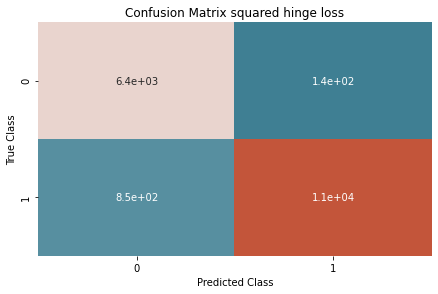

In [39]:
y_pred = neural_network_squared_hinge.predict(X_test)
y_pred=(y_pred > 0.5)
accuracy_squared_hinge = accuracy_score(y_test, y_pred)
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=target_names))
matrix = confusion_matrix(y_test, y_pred)
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(dataframe, annot=True, cbar=None, cmap=cmap)
plt.title("Confusion Matrix squared hinge loss"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

<h2> Kullback-Leibler divergence </h2>

In [46]:
def create_network_KL():
    network = Sequential()
    network.add(layers.Dense(units=10, activation="relu",input_shape=(number_of_features,)))
    network.add(layers.Dense(units=6, activation="relu"))
    network.add(layers.Dense(units=1, activation="sigmoid"))
    network.compile(loss="kullback_leibler_divergence", optimizer="adam", metrics=["accuracy"])
    return network 

In [47]:
neural_network_KL = KerasClassifier(build_fn=create_network_KL, epochs=100, batch_size=100, verbose=0)
print("Cross-validation score - Kullback-Leibler divergence loss function" ,cross_val_score(neural_network_KL, X_scaled, y, cv=20))

Cross-validation score - Kullback-Leibler divergence loss function [0.63366669 0.64399999 0.64099997 0.62900001 0.63999999 0.64200002
 0.63300002 0.63366669 0.64999998 0.63366669 0.63366669 0.64399999
 0.64099997 0.62900001 0.63999999 0.64200002 0.63300002 0.63366669
 0.64999998 0.63366669]


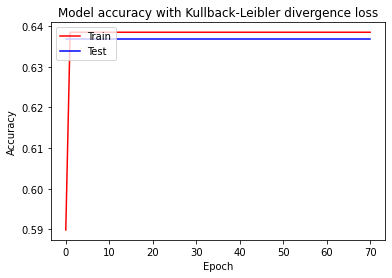

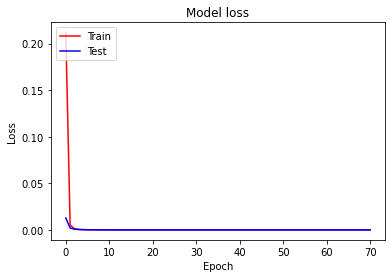

In [48]:
history_KL=neural_network_KL.fit(X_train, y_train,callbacks=callbacks, validation_data = (X_test,y_test))
plt.plot(history_KL.history['accuracy'], "r-")
plt.plot(history_KL.history['val_accuracy'],  "b-")
plt.title('Model accuracy with Kullback-Leibler divergence loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.plot(history_KL.history['loss'],"r-") 
plt.plot(history_KL.history['val_loss'],"b-") 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()


Classification report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6536
           1       0.64      1.00      0.78     11464

    accuracy                           0.64     18000
   macro avg       0.32      0.50      0.39     18000
weighted avg       0.41      0.64      0.50     18000



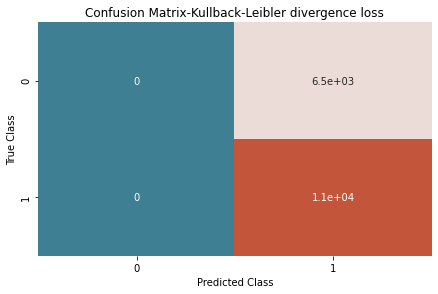

In [52]:
y_pred = neural_network_KL.predict(X_test)
y_pred=(y_pred > 0.5)
accuracy_KL = accuracy_score(y_test, y_pred)
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=target_names))
matrix = confusion_matrix(y_test, y_pred)
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(dataframe, annot=True, cbar=None, cmap=cmap)
plt.title("Confusion Matrix-Kullback-Leibler divergence loss"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

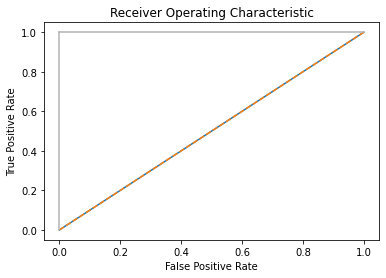

In [217]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test,
 y_pred)
plt.title("Receiver Operating Characteristic")
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

<h2> Dobijene tačnosti sa različitim loss funkcijama </h2>

Text(0.5, 0, 'Loss function')

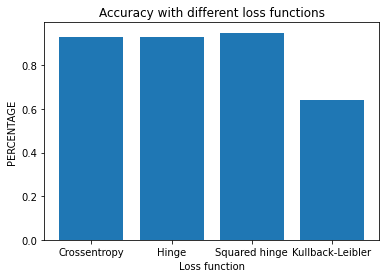

In [53]:
name =[ 'Crossentropy','Hinge', 'Squared hinge','Kullback-Leibler']
accuracy = (round(accuracy_crossentropy, 2),round(accuracy_hinge, 2),round(accuracy_squared_hinge, 2),round(accuracy_KL, 2))
bars=plt.bar(name, accuracy)
plt.title("Accuracy with different loss functions")
plt.ylabel('PERCENTAGE')
plt.xlabel('Loss function')

<h1> Regularizacija </h1>

Regularizacija je postupak za smanjenja overfittinga.

<h2> Dropout regularizacija </h2>

Model proizvoljno odbacuje, ili deaktivira nekoliko neurona oređenog sloja tokom svake iteracije. Prema tome, u svakoj iteraciji model  gleda na malo drugačiju sopstvenu strukturu, kako bi je optimizovala. Osim što smanjuje overfitting, efikana je i zbog smanjenog računanja, što utiče na performanse.

In [32]:
network_dropout = Sequential()
network_dropout.add(layers.Dropout(0.2, input_shape=(number_of_features,)))
network_dropout.add(layers.Dense(units=10, activation="relu"))
network_dropout.add(layers.Dropout(0.5))
network_dropout.add(layers.Dense(units=6, activation="relu"))
network_dropout.add(layers.Dropout(0.5))
network_dropout.add(layers.Dense(units=1, activation="sigmoid"))
network_dropout.compile(loss="squared_hinge", optimizer="adam", metrics=["accuracy"])
history_dropout=network_dropout.fit(X_train, y_train,validation_data = (X_test,y_test), batch_size=100 , epochs=100 )

Epoch 1/100
420/420 [==============================] - 3s 3ms/step - loss: 0.9806 - accuracy: 0.4200 - val_loss: 0.7438 - val_accuracy: 0.5705
Epoch 2/100
420/420 [==============================] - 1s 2ms/step - loss: 0.8282 - accuracy: 0.4938 - val_loss: 0.6751 - val_accuracy: 0.7022
Epoch 3/100
420/420 [==============================] - 1s 2ms/step - loss: 0.7844 - accuracy: 0.5318 - val_loss: 0.6576 - val_accuracy: 0.7426
Epoch 4/100
420/420 [==============================] - 1s 2ms/step - loss: 0.7697 - accuracy: 0.5567 - val_loss: 0.6419 - val_accuracy: 0.7612
Epoch 5/100
420/420 [==============================] - 1s 2ms/step - loss: 0.7479 - accuracy: 0.6375 - val_loss: 0.6376 - val_accuracy: 0.7658
Epoch 6/100
420/420 [==============================] - 1s 2ms/step - loss: 0.7340 - accuracy: 0.6966 - val_loss: 0.6319 - val_accuracy: 0.7772
Epoch 7/100
420/420 [==============================] - 1s 3ms/step - loss: 0.7369 - accuracy: 0.6994 - val_loss: 0.6317 - val_accuracy: 0.7779

Epoch 58/100
420/420 [==============================] - 1s 3ms/step - loss: 0.7206 - accuracy: 0.7290 - val_loss: 0.6045 - val_accuracy: 0.8042
Epoch 59/100
420/420 [==============================] - 1s 2ms/step - loss: 0.7251 - accuracy: 0.7243 - val_loss: 0.6087 - val_accuracy: 0.8009
Epoch 60/100
420/420 [==============================] - 1s 2ms/step - loss: 0.7235 - accuracy: 0.7233 - val_loss: 0.6042 - val_accuracy: 0.8071
Epoch 61/100
420/420 [==============================] - 1s 2ms/step - loss: 0.7241 - accuracy: 0.7313 - val_loss: 0.6050 - val_accuracy: 0.7998
Epoch 62/100
420/420 [==============================] - 1s 2ms/step - loss: 0.7234 - accuracy: 0.7253 - val_loss: 0.6064 - val_accuracy: 0.7983
Epoch 63/100
420/420 [==============================] - 1s 2ms/step - loss: 0.7243 - accuracy: 0.7242 - val_loss: 0.6036 - val_accuracy: 0.8021
Epoch 64/100
420/420 [==============================] - 1s 2ms/step - loss: 0.7271 - accuracy: 0.7211 - val_loss: 0.6042 - val_accuracy:

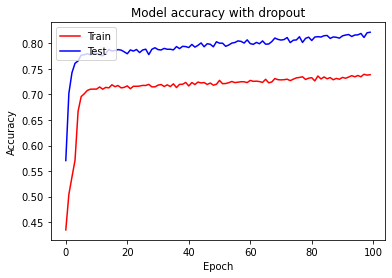

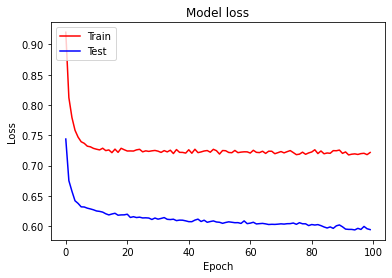

In [33]:
plt.plot(history_dropout.history['accuracy'], "r-")
plt.plot(history_dropout.history['val_accuracy'],  "b-")
plt.title('Model accuracy with dropout')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.plot(history_dropout.history['loss'],"r-") 
plt.plot(history_dropout.history['val_loss'],"b-") 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [45]:
y_pred = network_dropout.predict(X_test)
y_pred=(y_pred > 0.5)
dropout_loss, dropout_acc = network_dropout.evaluate(X_test,  y_test, verbose=2)
print("Loss: ", dropout_loss)
print("Accuracy: ", dropout_acc)

563/563 - 1s - loss: 0.5943 - accuracy: 0.8221
Loss:  0.5942971110343933
Accuracy:  0.8220555782318115


<h2> L1 regularizacija </h2>

Proces regularizacije se može prikazati kao
cost funkcija = loss (kako je definisano za model) + hiperparametar × [weights] (težine)
<br>
Na osnovu načina na koji se težine dodaju loss funkciji, postoje L1 i L2 regularizacija.

In [46]:
model = Sequential()
model.add(Dense( 10,  kernel_initializer = 'uniform', activation = 'relu' ,kernel_regularizer=regularizers.l1(0.01), input_dim = 12))
model.add(Dense( 6,  kernel_initializer = 'uniform', activation = 'relu',kernel_regularizer=regularizers.l1(0.01)))
model.add(Dense( 1,  kernel_initializer = 'uniform', activation = 'sigmoid',))
model.compile(optimizer = 'adam', loss ='binary_crossentropy' , metrics = ["accuracy"])
history_l1=model.fit(X_train, y_train,validation_data = (X_test,y_test), batch_size=100 , epochs=100 )

Epoch 1/100
420/420 [==============================] - 3s 3ms/step - loss: 0.6829 - accuracy: 0.6350 - val_loss: 0.6555 - val_accuracy: 0.6367
Epoch 2/100
420/420 [==============================] - 1s 2ms/step - loss: 0.6574 - accuracy: 0.6335 - val_loss: 0.6556 - val_accuracy: 0.6367
Epoch 3/100
420/420 [==============================] - 1s 2ms/step - loss: 0.6536 - accuracy: 0.6402 - val_loss: 0.6555 - val_accuracy: 0.6367
Epoch 4/100
420/420 [==============================] - 1s 2ms/step - loss: 0.6562 - accuracy: 0.6356 - val_loss: 0.6555 - val_accuracy: 0.6367
Epoch 5/100
420/420 [==============================] - 1s 3ms/step - loss: 0.6543 - accuracy: 0.6389 - val_loss: 0.6555 - val_accuracy: 0.6367
Epoch 6/100
420/420 [==============================] - 1s 2ms/step - loss: 0.6549 - accuracy: 0.6378 - val_loss: 0.6557 - val_accuracy: 0.6367
Epoch 7/100
420/420 [==============================] - 1s 3ms/step - loss: 0.6533 - accuracy: 0.6407 - val_loss: 0.6555 - val_accuracy: 0.6367

Epoch 58/100
420/420 [==============================] - 1s 3ms/step - loss: 0.6568 - accuracy: 0.6349 - val_loss: 0.6555 - val_accuracy: 0.6367
Epoch 59/100
420/420 [==============================] - 1s 3ms/step - loss: 0.6533 - accuracy: 0.6406 - val_loss: 0.6557 - val_accuracy: 0.6367
Epoch 60/100
420/420 [==============================] - 1s 2ms/step - loss: 0.6543 - accuracy: 0.6389 - val_loss: 0.6555 - val_accuracy: 0.6367
Epoch 61/100
420/420 [==============================] - 1s 2ms/step - loss: 0.6533 - accuracy: 0.6409 - val_loss: 0.6555 - val_accuracy: 0.6367
Epoch 62/100
420/420 [==============================] - 1s 2ms/step - loss: 0.6543 - accuracy: 0.6388 - val_loss: 0.6556 - val_accuracy: 0.6367
Epoch 63/100
420/420 [==============================] - 1s 2ms/step - loss: 0.6545 - accuracy: 0.6386 - val_loss: 0.6555 - val_accuracy: 0.6367
Epoch 64/100
420/420 [==============================] - 1s 2ms/step - loss: 0.6524 - accuracy: 0.6423 - val_loss: 0.6555 - val_accuracy:

In [48]:
y_pred = model.predict(X_test)
y_pred=(y_pred > 0.5)
l1_loss, l1_acc = model.evaluate(X_test,  y_test, verbose=2)
print("Loss: ", l1_loss)
print("Accuracy: ", l1_acc)

563/563 - 1s - loss: 0.6555 - accuracy: 0.6367
Loss:  0.6555068492889404
Accuracy:  0.636722207069397


<h2> L2 regularizacija </h2>

In [49]:
model = Sequential()
model.add(Dense( 10,  kernel_initializer = 'uniform', activation = 'relu' ,kernel_regularizer=regularizers.l2(0.01), input_dim = 12))
model.add(Dense( 6,  kernel_initializer = 'uniform', activation = 'relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense( 1,  kernel_initializer = 'uniform', activation = 'sigmoid',))
model.compile(optimizer = 'adam', loss ='binary_crossentropy' , metrics = ["accuracy"])
history_l2=model.fit(X_train, y_train,validation_data = (X_test,y_test), batch_size=100 , epochs=100 )

Epoch 1/100
420/420 [==============================] - 2s 3ms/step - loss: 0.6456 - accuracy: 0.6340 - val_loss: 0.5149 - val_accuracy: 0.8007
Epoch 2/100
420/420 [==============================] - 1s 2ms/step - loss: 0.5069 - accuracy: 0.8005 - val_loss: 0.4828 - val_accuracy: 0.8072
Epoch 3/100
420/420 [==============================] - 1s 2ms/step - loss: 0.4749 - accuracy: 0.8138 - val_loss: 0.4627 - val_accuracy: 0.8118
Epoch 4/100
420/420 [==============================] - 1s 2ms/step - loss: 0.4571 - accuracy: 0.8169 - val_loss: 0.4492 - val_accuracy: 0.8118
Epoch 5/100
420/420 [==============================] - 1s 2ms/step - loss: 0.4481 - accuracy: 0.8136 - val_loss: 0.4409 - val_accuracy: 0.8128
Epoch 6/100
420/420 [==============================] - 1s 2ms/step - loss: 0.4394 - accuracy: 0.8142 - val_loss: 0.4341 - val_accuracy: 0.8121
Epoch 7/100
420/420 [==============================] - 1s 2ms/step - loss: 0.4305 - accuracy: 0.8166 - val_loss: 0.4296 - val_accuracy: 0.8134

Epoch 58/100
420/420 [==============================] - 1s 2ms/step - loss: 0.4005 - accuracy: 0.8175 - val_loss: 0.4051 - val_accuracy: 0.8117
Epoch 59/100
420/420 [==============================] - 1s 2ms/step - loss: 0.4001 - accuracy: 0.8145 - val_loss: 0.4032 - val_accuracy: 0.8126
Epoch 60/100
420/420 [==============================] - 1s 2ms/step - loss: 0.4011 - accuracy: 0.8143 - val_loss: 0.4030 - val_accuracy: 0.8136
Epoch 61/100
420/420 [==============================] - 1s 3ms/step - loss: 0.4012 - accuracy: 0.8144 - val_loss: 0.4042 - val_accuracy: 0.8121
Epoch 62/100
420/420 [==============================] - 1s 2ms/step - loss: 0.4014 - accuracy: 0.8153 - val_loss: 0.4033 - val_accuracy: 0.8122
Epoch 63/100
420/420 [==============================] - 1s 2ms/step - loss: 0.4017 - accuracy: 0.8157 - val_loss: 0.4030 - val_accuracy: 0.8125
Epoch 64/100
420/420 [==============================] - 1s 2ms/step - loss: 0.4034 - accuracy: 0.8123 - val_loss: 0.4022 - val_accuracy:

In [50]:
y_pred = model.predict(X_test)
y_pred=(y_pred > 0.5)
l2_loss, l2_acc = model.evaluate(X_test,  y_test, verbose=2)
print("Loss: ", l2_loss)
print("Accuracy: ", l2_acc)

563/563 - 1s - loss: 0.4012 - accuracy: 0.8131
Loss:  0.4012114703655243
Accuracy:  0.8131111264228821


<h2> Custom loss funkcija </h2>

Varijanta logaritamske loss funkcije sa negativnim predznakom.
Kada je y_true = 1 (slučaj kada je pametna mreža nestabilna jer je 1=unstable), loss je tipični logaritamski gubitak. 
Kada je y_true = 0 (stablina mreža): ako je predviđeno  0.2, to je dobro (gubitak mali); ako je y_pred 0.5 nije tako loše, ali sto je veće y_pred, veći je gubitak, loše je predviđanje.

In [87]:
def custom_loss(y_true, y_pred):
    y_true=tf.cast(y_true, tf.float32)
    loss= -(y_true*K.log(y_pred) - (1-y_true)*K.log(1-y_pred)**2)
    loss = K.sum(loss, axis=1)       
    
    return loss

In [106]:
classifier_cl = Sequential()
classifier_cl.add(Dense( 10,  kernel_initializer = 'uniform', activation = 'relu' , input_dim = 12,dtype='float32'))
classifier_cl.add(Dense( 6,  kernel_initializer = 'uniform', activation = 'relu'))
classifier_cl.add(Dense( 1,  kernel_initializer = 'uniform', activation = 'sigmoid'))

In [107]:
classifier_cl.compile(optimizer = 'adam', loss =custom_loss , metrics = ["accuracy"], run_eagerly=True )

In [108]:
history_cl=classifier_cl.fit(X_train, y_train,validation_data = (X_test,y_test), batch_size=100 , epochs=100 )

Epoch 1/100
420/420 [==============================] - 10s 24ms/step - loss: 0.5370 - accuracy: 0.7169 - val_loss: 0.3823 - val_accuracy: 0.8073
Epoch 2/100
420/420 [==============================] - 10s 24ms/step - loss: 0.3707 - accuracy: 0.8145 - val_loss: 0.3365 - val_accuracy: 0.8414
Epoch 3/100
420/420 [==============================] - 10s 24ms/step - loss: 0.3254 - accuracy: 0.8452 - val_loss: 0.2771 - val_accuracy: 0.8794
Epoch 4/100
420/420 [==============================] - 10s 24ms/step - loss: 0.2575 - accuracy: 0.8832 - val_loss: 0.2269 - val_accuracy: 0.9043
Epoch 5/100
420/420 [==============================] - 10s 25ms/step - loss: 0.2236 - accuracy: 0.9068 - val_loss: 0.2118 - val_accuracy: 0.9111
Epoch 6/100
420/420 [==============================] - 10s 23ms/step - loss: 0.2066 - accuracy: 0.9147 - val_loss: 0.2090 - val_accuracy: 0.9123
Epoch 7/100
420/420 [==============================] - 10s 24ms/step - loss: 0.2060 - accuracy: 0.9155 - val_loss: 0.2073 - val_ac

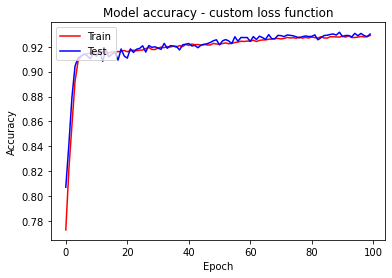

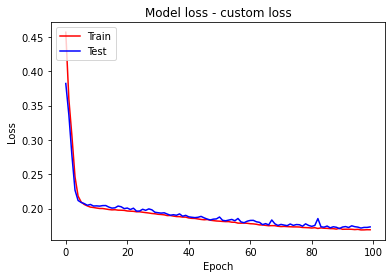

In [109]:
plt.plot(history_cl.history['accuracy'], "r-")
plt.plot(history_cl.history['val_accuracy'],  "b-")
plt.title('Model accuracy - custom loss function')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.plot(history_cl.history['loss'],"r-") 
plt.plot(history_cl.history['val_loss'],"b-") 
plt.title('Model loss - custom loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

<h1> Redukcija dimenzionalnosti </h1>

<h2> Da li PCA može poboljšati rezultate klasifikacije kod veštačkih neuronskih mreža? </h2>

In [12]:
X_red=X
X_red.shape

(60000, 12)

(60000, 7) compnents to preserve 99% of the variability in data


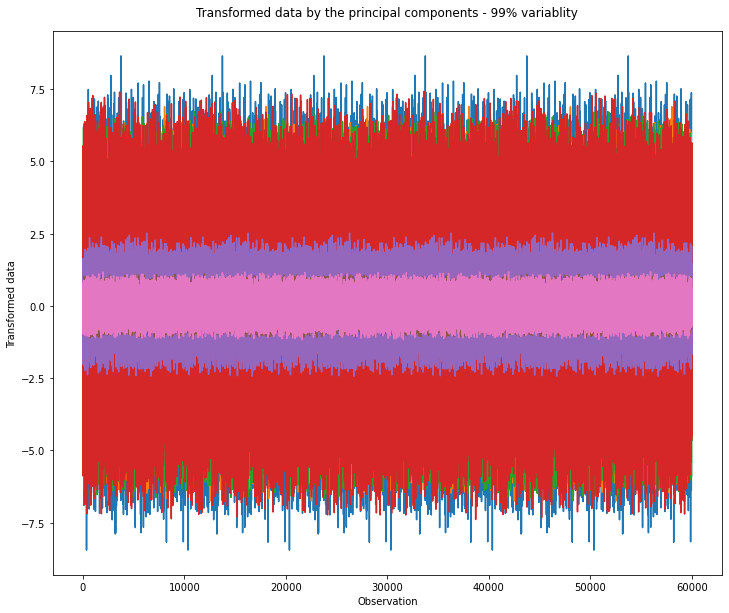

In [23]:
pca_99=PCA(n_components=0.99, random_state=2000)
pca_99.fit(X_red)
X_pca_99=pca_99.transform(X_red)
plt.figure(figsize=(12,10))
plt.plot(X_pca_99)
plt.title('Transformed data by the principal components - 99% variablity',pad=15)
plt.xlabel('Observation')
plt.ylabel('Transformed data')
print("{} compnents to preserve 99% of the variability in data".format(X_pca_99.shape))

In [51]:
scale = StandardScaler()
X_scaled_99 = scale.fit_transform(X_pca_99)
X_train_99,X_test_99,y_train_99,y_test_99=train_test_split(X_scaled_99,y,test_size=0.3)

In [52]:
number_of_features=7
network = Sequential()
network.add(layers.Dense(units=10, activation="relu",input_shape=(number_of_features,)))
network.add(layers.Dense(units=6, activation="relu"))
network.add(layers.Dense(units=1, activation="sigmoid"))
network.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history=network.fit(X_train_99, y_train_99,callbacks=callbacks,validation_data = (X_test_99,y_test_99), batch_size=100 , epochs=100 )

Epoch 1/100
420/420 [==============================] - 2s 3ms/step - loss: 0.7328 - accuracy: 0.6536 - val_loss: 0.5509 - val_accuracy: 0.7136
Epoch 2/100
420/420 [==============================] - 1s 2ms/step - loss: 0.5384 - accuracy: 0.7258 - val_loss: 0.5285 - val_accuracy: 0.7286
Epoch 3/100
420/420 [==============================] - 1s 2ms/step - loss: 0.5291 - accuracy: 0.7300 - val_loss: 0.5182 - val_accuracy: 0.7393
Epoch 4/100
420/420 [==============================] - 1s 3ms/step - loss: 0.5077 - accuracy: 0.7489 - val_loss: 0.5081 - val_accuracy: 0.7487
Epoch 5/100
420/420 [==============================] - 1s 2ms/step - loss: 0.5008 - accuracy: 0.7525 - val_loss: 0.4948 - val_accuracy: 0.7585
Epoch 6/100
420/420 [==============================] - 1s 2ms/step - loss: 0.4889 - accuracy: 0.7637 - val_loss: 0.4831 - val_accuracy: 0.7654
Epoch 7/100
420/420 [==============================] - 1s 3ms/step - loss: 0.4757 - accuracy: 0.7737 - val_loss: 0.4759 - val_accuracy: 0.7710

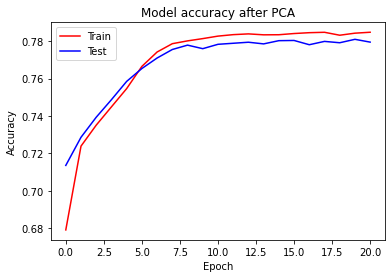

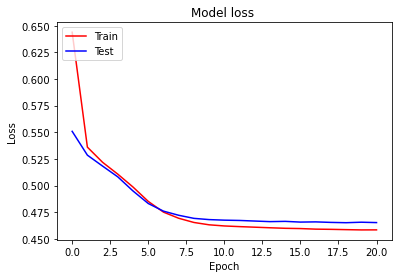

In [53]:
plt.plot(history.history['accuracy'], "r-")
plt.plot(history.history['val_accuracy'],  "b-")
plt.title('Model accuracy after PCA')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'],"r-") 
plt.plot(history.history['val_loss'],"b-") 
plt.title('Model loss ') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()


Classification report:

              precision    recall  f1-score   support

           0       0.73      0.64      0.68      6622
           1       0.80      0.86      0.83     11378

    accuracy                           0.78     18000
   macro avg       0.77      0.75      0.76     18000
weighted avg       0.78      0.78      0.78     18000



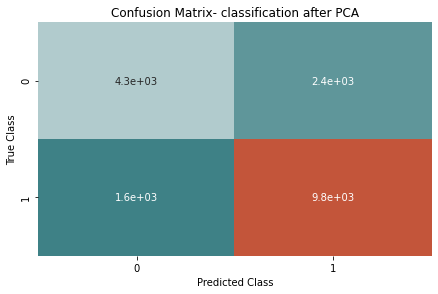

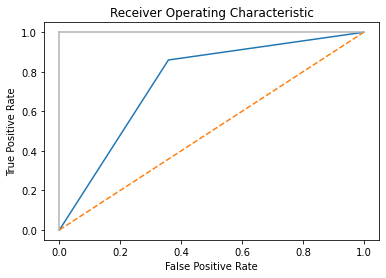

563/563 - 1s - loss: 0.4652 - accuracy: 0.7795
Loss:  0.465190052986145
Accuracy:  0.7795000076293945


In [55]:
y_pred_99 = network.predict(X_test_99)
y_pred_99=(y_pred_99 > 0.5)
print("\nClassification report:\n")
target_names = ['0', '1']
class_names=[0,1]
print(classification_report(y_test_99, y_pred_99, target_names=target_names))
matrix = confusion_matrix(y_test_99, y_pred_99)
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)
cmap = sns.diverging_palette(200, 20, as_cmap=True)
sns.heatmap(dataframe, annot=True, cbar=None, cmap=cmap)
plt.title("Confusion Matrix- classification after PCA"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_99,
 y_pred_99)
plt.title("Receiver Operating Characteristic")
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()
pca_loss, pca_acc = network.evaluate(X_test_99,  y_test_99, verbose=2)
print("Loss: ", pca_loss)
print("Accuracy: ", pca_acc)

<h1> Zaključak </h1>

Nakon PCA, rezultati klasifikacije su znatno lošiji. Redukcija dimenzionlanosti nije poboljšala rezultate, ali se neuronske mreže mogu koristiti za smanjenje dimenzionalnosti, kod drugih problema. Koriste se auto-enkoderi.
Auto-enkoder je vrsta nenadgledane neuronske mreže koja se koristi za smanjenje dimenzionalnosti i otkrivanje karakteristika. Tačnije, auto-enkoder je neuronska mreža koja je obučena da predviđa sam ulaz.


Kreirana neuronska mreža je u nekim slučajevima dala jako dobre rezultate. Rezultati su bili lošiji onda kada su korišćene tehnike smanjivanja overfittinga.
Neuronska mreža je jako dobro obučena i dala je dobre rezultate onda kada je kreirana custom loss funkcija, koja je prilagođena problemu.
